<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter08/Training_Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Object detection 
The drawback of the R-CNN and Fast R-CNN techniques is that they have two disjointed networks – one to identify the regions that likely contain an object and the other to make corrections to the bounding box where an object is identified.
Furthermore, both the models require as many forward propagations as there are region proposals.  
Modern object detection algorithms focus heavily on training a single neural network and have the capability to detect all objects in one forward pass.   
In the subsequent sections, we will learn about the various components of a typical modern object detection algorithm:
- Anchor boxes
- Region proposal network (RPN)
- Region of interest pooling

## Anchor boxes
Anchor boxes come in as a handy replacement for selective search. 
Typically, a majority of objects have a similar shape. Thus, we will have a decent idea of the height and width of the objects present in an image even before training the model (by inspecting the ground truths of bounding boxes corresponding to objects of various classes).  

Once we have a decent idea of the aspect ratio and the height and width of objects (which can be obtained from ground truth values in the dataset) present in our images, we define the anchor boxes with heights and widths representing the majority of objects' bounding boxes within our dataset. Typically, this is obtained by employing K-means clustering on top of the ground
truth bounding boxes of objects present in images.  

once we know the various widths and heights of anchor boxes we use it as follows:
1. Slide each anchor box over an image from top left to bottom right.
2. The anchor box that has a high intersection over union (IoU) with the object will have a label that mentions that it contains an object, and the others will be labeled 0:
  - We can modify the threshold of the IoU by mentioning that if the IoU is greater than a certain threshold, the object class is 1; if it is less than another threshold, the object class is 0, and it is unknown otherwise.  
  
Once we obtain the ground truths as defined here, we can build a model that can predict the location of an object and also the offset corresponding to the anchor box to match it with ground truth.  
![anchor](./anchor_box.png)  
We slide the two anchor boxes over the image and note the locations where the IoU of the anchor box with the ground truth is the highest and denote that this particular location contains an object while the rest of the locations do not contain an object.  

In addition to the preceding two anchor boxes, we would also create anchor boxes with varying scales so that we accommodate the differing scales at which an object can be presented within an image. 

## Region Proposal Network
Imagine a scenario where we have a 224 x 224 x 3 image. Furthermore, let's say that the anchor box is of shape 8 x 8 for this example. If we have a stride of 8 pixels, we are fetching 224/8 = 28 crops of a picture for every row – essentially 28\*28 = 576 crops from a picture. We then take each of these crops and pass through a Region Proposal Network model (RPN) that indicates whether the crop contains an image. Essentially, an RPN suggests the likelihood of a crop containing an object.  

`selectivesearch` gives a region candidates based on a set of computations on top of pixel values. However, an RPN generates region candidates based on the anchor boxes and the strides with which anchor boxes are slid over the image. Once we obtain the region candidates using either of these two methods, we identify the candidates that are most likely to contain an object.  

While region proposal generation based on `selectivesearch` is done outside of the neural network, we can build an RPN that is a part of the object detection network. Using an RPN, we are now in a position where we don't have to perform unnecessary computations to calculate region proposals outside of the network. This way, we have a single model to identify regions, identify classes of objects in image, and identify their corresponding bounding box locations.  

Next, we will learn how an RPN identifies whether a region candidate (a crop obtained after sliding an anchor box) contains an object or not. In our training data, we would have the ground truth correspond to objects. We now take each region candidate and compare with the ground truth bounding boxes of objects in an image to identify whether the IoU between a region candidate and a ground truth bounding box is greater than a certain threshold. If the IoU is greater than a certain threshold (say, 0.5), the region candidate contains an object, and if the IoU is less than a threshold (say 0.1), the region candidate does not contain an object and all the candidates that have an IoU between the two thresholds (0.1 - 0.5) are ignored while training.   
Once we train a model to predict if the region candidate contains an object, we then perform non-max suppression, as multiple overlapping regions can contain an object.  

In summary, an RPN trains a model to enable it to identify region proposals with a high likelihood of containing an object by performing the following steps:
1. Slide anchor boxes of different aspect ratios and sizes across the image to fetch crops of an image.
2. Calculate the IoU between the ground truth bounding boxes of objects in the image and the crops obtained in the previous step.
3. Prepare the training dataset in such a way that crops with an IoU greater than a threshold contain an object and crops with an IoU less than a threshold do not contain an object.
4. Train the model to identify regions that contain an object.
5. Perform non-max suppression to identify the region candidate that has the highest probability of containing an object and eliminate other region candidates that have a high overlap with it.

![rpn1](rpn1.png)

In the preceding diagram, we are taking the output of RoI pooling as input (the 7 x 7 x 512 shape), flattening it, and connecting to a dense layer before predicting two different aspects:
1. Class of object in the region
2. Amount of offset to be done on the predicted bounding boxes of the region to maximize the IoU with the ground truth  

Hence, if there are 20 classes in the data, the output of the neural network contains a total of 25 outputs – 21 classes (including the background class) and the 4 offsets to be applied to the height, width, and two center coordinates of the bounding box.  

Now that we have learned the different components of an object detection pipeline, let's summarize it with the following diagram:
![rpn2](rpn2.png)


In [1]:
import os
# if not os.path.exists('images'):
#     !pip install -qU torch_snippets
#     from google.colab import files
#     files.upload() # upload kaggle.json
#     !mkdir -p ~/.kaggle
#     !mv kaggle.json ~/.kaggle/
#     !ls ~/.kaggle
#     !chmod 600 /root/.kaggle/kaggle.json
#     !kaggle datasets download -d sixhky/open-images-bus-trucks/
#     !unzip -qq open-images-bus-trucks.zip
#     !rm open-images-bus-trucks.zip

In [2]:
from torch_snippets import *
from PIL import Image
# IMAGE_ROOT = 'images/images'
# DF_RAW = df = pd.read_csv('df.csv')
IMAGE_ROOT = os.path.expanduser('~/datasets/open-images-bus-trucks/images')
DF_RAW = df = pd.read_csv(os.path.expanduser('~/datasets/open-images-bus-trucks/df.csv'))
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

In [3]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [4]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [5]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = Glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()  # each image can appear more than once if it has multiple objects
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        # torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 

    def __len__(self):
        return len(self.image_infos)

In [6]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)   # replacing the head in order to train it
    return model

In [8]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Looking a the model we've loaded we see it is built from several modules. each defined by a class:
- `GeneralizedRCNNTransform` is a simple resize followed by a normalize transformation
- `BackboneWithFPN` is a neural network that transforms input into a feature map.
- `RegionProposalNetwork` generates the anchor boxes for the preceding feature map and predicts individual feature maps for classification and regression tasks
- `RoIHeads` takes the preceding maps, aligns them using RoI pooling, processes them, and returns classification probabilities for each proposal and the corresponding offsets

In [32]:
from torchsummary import summary
inputs = next(iter(train_loader))
inp,_=inputs
summary(model)
# summary(model,input_data=torch.stack(inp).shape)

Layer (type:depth-idx)                   Param #
├─GeneralizedRCNNTransform: 1-1          --
├─BackboneWithFPN: 1-2                   --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─FrozenBatchNorm2d: 3-2       --
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (212,992)
|    |    └─Sequential: 3-6              1,212,416
|    |    └─Sequential: 3-7              7,077,888
|    |    └─Sequential: 3-8              14,942,208
|    └─FeaturePyramidNetwork: 2-2        --
|    |    └─ModuleList: 3-9              984,064
|    |    └─ModuleList: 3-10             2,360,320
|    |    └─LastLevelMaxPool: 3-11       --
├─RegionProposalNetwork: 1-3             --
|    └─AnchorGenerator: 2-3              --
|    └─RPNHead: 2-4                      --
|    |    └─Conv2d: 3-12                 590,080
|    |    └─Conv2d: 3-13                 771
|    |    └─Conv2d:

Layer (type:depth-idx)                   Param #
├─GeneralizedRCNNTransform: 1-1          --
├─BackboneWithFPN: 1-2                   --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─FrozenBatchNorm2d: 3-2       --
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (212,992)
|    |    └─Sequential: 3-6              1,212,416
|    |    └─Sequential: 3-7              7,077,888
|    |    └─Sequential: 3-8              14,942,208
|    └─FeaturePyramidNetwork: 2-2        --
|    |    └─ModuleList: 3-9              984,064
|    |    └─ModuleList: 3-10             2,360,320
|    |    └─LastLevelMaxPool: 3-11       --
├─RegionProposalNetwork: 1-3             --
|    └─AnchorGenerator: 2-3              --
|    └─RPNHead: 2-4                      --
|    |    └─Conv2d: 3-12                 590,080
|    |    └─Conv2d: 3-13                 771
|    |    └─Conv2d:

In [33]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

In [ ]:
model

In [34]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

/home/guy/anaconda3/envs/ptvit/lib/python3.8/site-packages/torch-1.10.1-py3.8-linux-x86_64.egg/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


EPOCH: 1.000	trn_loss: 0.184	trn_loc_loss: 0.076	trn_regr_loss: 0.083	trn_objectness_loss: 0.017	trn_rpn_box_reg_loss: 0.008	val_loss: 0.172	val_loc_loss: 0.069	val_regr_loss: 0.079	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.009	(2551.79s - 10207.17s remaining)
EPOCH: 2.000	trn_loss: 0.156	trn_loc_loss: 0.065	trn_regr_loss: 0.074	trn_objectness_loss: 0.010	trn_rpn_box_reg_loss: 0.007	val_loss: 0.173	val_loc_loss: 0.071	val_regr_loss: 0.079	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.009	(5077.70s - 7616.55s remaining)
EPOCH: 3.000	trn_loss: 0.146	trn_loc_loss: 0.060	trn_regr_loss: 0.071	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.007	val_loss: 0.176	val_loc_loss: 0.071	val_regr_loss: 0.081	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.009	(7604.01s - 5069.34s remaining)
EPOCH: 4.000	trn_loss: 0.140	trn_loc_loss: 0.057	trn_regr_loss: 0.069	trn_objectness_loss: 0.008	trn_rpn_box_reg_loss: 0.007	val_loss: 0.186	val_loc_loss: 0.076	val_regr_loss: 0.083	val_object

In [ ]:
whos

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 409.41it/s]


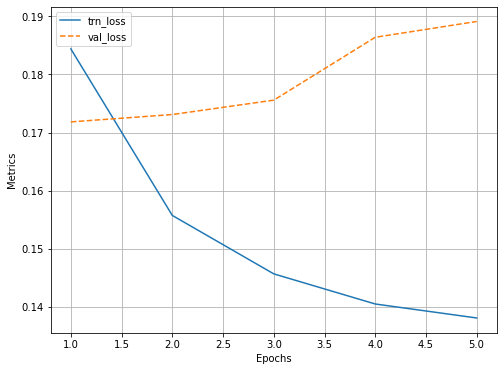

In [35]:
log.plot_epochs(['trn_loss','val_loss'])

In [36]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


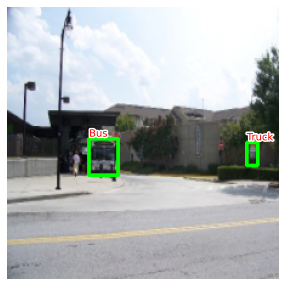

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


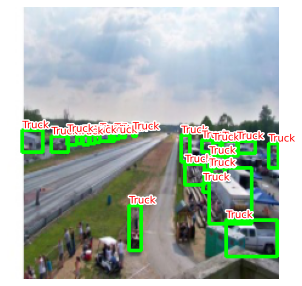

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


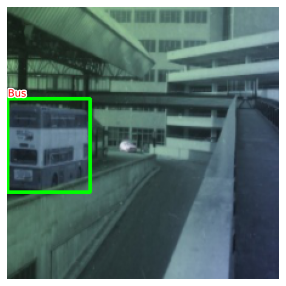

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


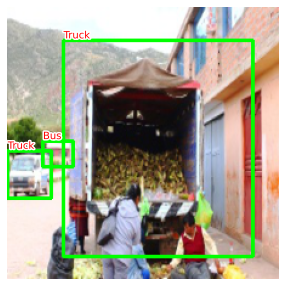

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


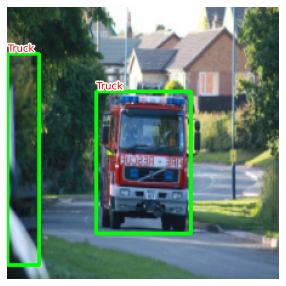

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


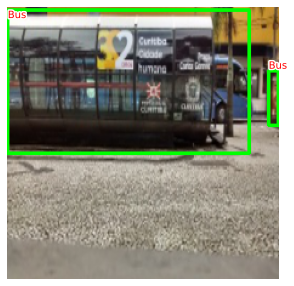

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


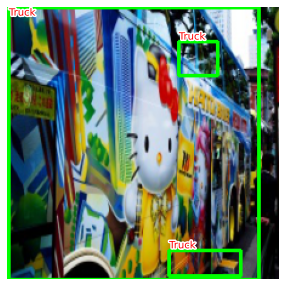

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


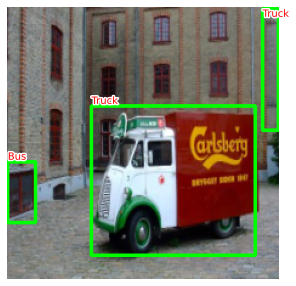

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


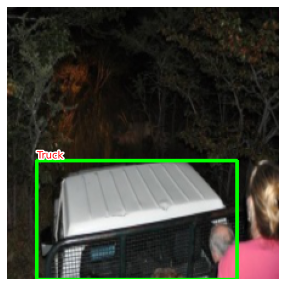

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


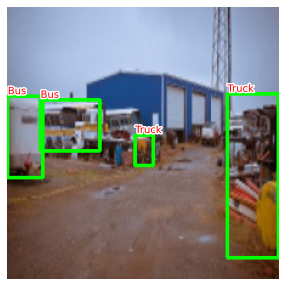

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


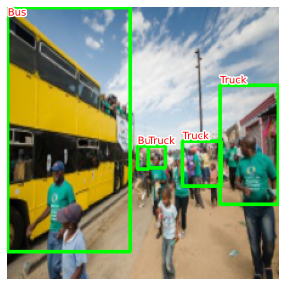

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


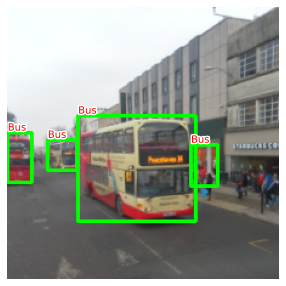

In [37]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)